# Neural Networks for Time Series

In this notebook, we'll cover topics related to learning from time series and sequential data.

## Preamble

This lab session deals with the use of neural networks for time series classification and forecasting.
Two kinds of architectures are considered here: convolutional and recurrent models. An illustration of attention-based models is provided at the end of the lab.

## Time Series Classification using convolutional models (ConvNets)

For a start, you will load the "Trace" dataset using [`tslearn` data loading tool](https://tslearn.readthedocs.io/en/latest/gen_modules/datasets/tslearn.datasets.CachedDatasets.html#tslearn.datasets.CachedDatasets.load_dataset).

**Question #1.** What are the dimensions of the training data (`X_train`)? And what does each dimension correspond to (number of series, number of timestamps, number of features, ...)?
Also, `keras` expects class information to be encoded as one-hot vectors. Use [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to format your `y` arrays accordingly.


In [1]:
from tslearn.datasets import CachedDatasets
from keras.utils import to_categorical

data_loader = CachedDatasets()

X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

y_train -= 1
y_test -= 1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, y_train.shape)

(100, 275, 1) (100, 4)


**Question #2.** In the following, you will be implementing a ConvNet using keras' [`Conv1D`](https://keras.io/api/layers/convolution_layers/convolution1d/) layers.
What value should be passed to the `data_format` parameter to match `tslearn` format? Is it the default value?

**Your Answer here.**

**Question #3.** `keras` has a `Sequential` model class that allows to build models by stacking layers.
Define a model that is made of the following layers (use ReLU activation wherever it makes sense):

* a convolution layer made of 10 filters of size 3
* a pooling layer of pool size 2
* a flatten layer (that converts a time series of features into a flattened array that is suited to feed fully-connected layers)
* a fully-connected layer that has as many neurons as the number of classes in the "Trace" problem, and an adequate activation function.

Compile your model (use "Adam" optimizer) and fit it for 10 epochs.

In [2]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv1D, MaxPool1D, Flatten, Dense

model = Sequential([
    InputLayer(input_shape=(275, 1)),
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10


/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-02-20 17:02:49.936350: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-02-20 17:02:49.936372: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-20 17:02:49.936379: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-20 17:02:49.936411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-20 17:02:49.936426: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefine

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.1602 - loss: 1.4983 - val_accuracy: 0.5000 - val_loss: 1.2433
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4748 - loss: 1.2130 - val_accuracy: 0.5200 - val_loss: 1.0606
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5883 - loss: 1.0235 - val_accuracy: 0.4000 - val_loss: 0.9519
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5096 - loss: 0.8978 - val_accuracy: 0.4000 - val_loss: 0.8842
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5579 - loss: 0.8184 - val_accuracy: 0.4200 - val_loss: 0.8414
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5579 - loss: 0.7673 - val_accuracy: 0.4300 - val_loss: 0.8010
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5423 - loss: 0.7293 - val_accuracy: 0.4900 - val_loss: 0.7633
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6135 - loss: 0.6989 - val_accuracy: 0.5500 - val_loss: 0.7373
Epoch 9/10

**Question #4.** Plot the evolution of accuracy through epochs on both training and validation sets.

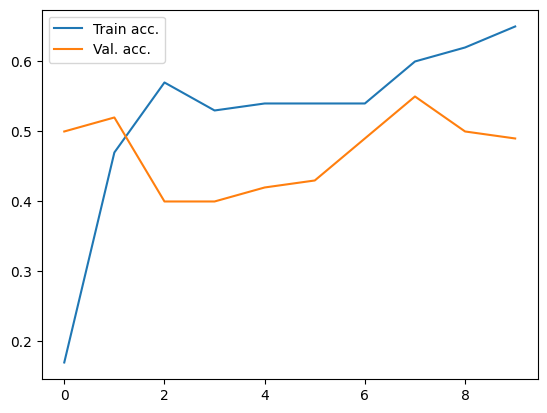

In [3]:
import matplotlib.pyplot as plt

plt.plot(h.history["accuracy"], label="Train acc.")
plt.plot(h.history["val_accuracy"], label="Val. acc.")
plt.legend();

**Question #5.** Ten epochs of training might not be sufficient, yet we do not know how many epochs would be necessary for a decent training. Set up early stopping (cf. [this callback](https://keras.io/api/callbacks/early_stopping/)) and see how long it takes before the model stops training.

In [4]:
from keras.callbacks import EarlyStopping

cb = EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

model = Sequential([
    InputLayer(input_shape=(275, 1)),
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[cb])

Epoch 1/100


/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.3702 - loss: 1.2601 - val_accuracy: 0.5000 - val_loss: 1.1452
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4235 - loss: 1.1264 - val_accuracy: 0.3800 - val_loss: 1.0486
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5238 - loss: 1.0177 - val_accuracy: 0.4300 - val_loss: 0.9716
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5229 - loss: 0.9337 - val_accuracy: 0.4800 - val_loss: 0.9048
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5927 - loss: 0.8676 - val_accuracy: 0.5100 - val_loss: 0.8543
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6194 - loss: 0.8142 - val_accuracy: 0.5100 - val_loss: 0.8109
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6246 - loss: 0.7712 - val_accuracy: 0.5100 - val_loss: 0.7781
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6283 - loss: 0.7335 - val_accuracy: 0.5200 - val_loss: 0.7557
Epo

## Recurrent neural nets

For this new part of the lab, we will use the data generated from the function below:

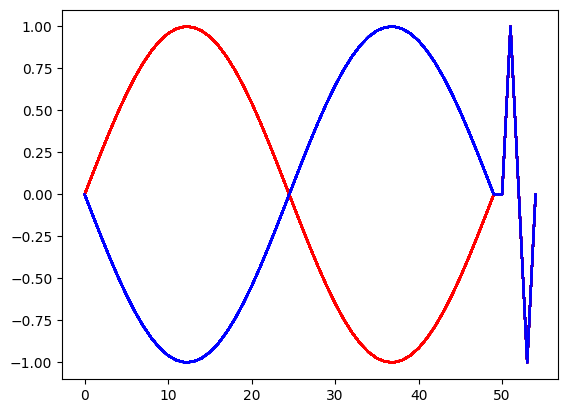

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def make_sines(n_series_per_class, length, length_padding=0):
    t = np.linspace(0, 2 * np.pi, num=length)
    X0 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X0[:, :length] = np.sin(t).reshape((1, -1))
    X0[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))
    
    X1 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X1[:, :length] = np.sin(-t).reshape((1, -1))
    X1[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))

    dataset = np.array([X0, X1]).reshape((2 * n_series_per_class, length + length_padding, 1))
    y = np.array([0] * n_series_per_class + [1] * n_series_per_class)

    indices = np.random.permutation(2 * n_series_per_class)
    return dataset[indices], y[indices]

np.random.seed(0)
X_train, y_train = make_sines(100, 50, length_padding=5)
X_test, y_test = make_sines(100, 50, length_padding=5)

plt.figure()
colors = ["r", "b"]
for ts, yi in zip(X_train, y_train):
    plt.plot(ts.ravel(), color=colors[yi])
plt.show()

**Question #7.** Implement your own recurrent layer (_cf._ formulas in the course) using the skeleton below and train a network
made of a single recurrent unit with a 8-dimensional hidden state followed by a fully connected layer, and evaluate its classification 
performance on the dataset provided above.

In [6]:
from keras.layers import Layer
from keras.ops import tanh, zeros

class CustomRecurrentUnit(Layer):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # List sets of parameters here
        self.w_h = self.add_weight(
            shape=(hidden_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_h = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
        self.w_i = self.add_weight(
            shape=(input_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_i = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
    
    def linear_hidden(self, h_t):
        return h_t @ self.w_h + self.b_h
    
    def linear_input(self, x_t):
        return x_t @ self.w_i + self.b_i
    
    def call(self, x):
        n_timestamps = x.shape[1]
        h = zeros((1, self.hidden_dim))  # Initialize h to [0, ..., 0]
        for t in range(n_timestamps):
            h = tanh(self.linear_hidden(h) + self.linear_input(x[:, t, :]))
        return h

**Question #8.** Implement a network made of a `CustomRecurrentUnit` followed by a fully-connected layer
for the classification task introduced above.
Evaluate this model both in terms of training loss and test-set accuracy (you can use the above callback to limit the amount of logging).

In [7]:
model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 515ms/step - accuracy: 0.4947 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5211 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.4766 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4739 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5175 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.4870 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.5121 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5238 - loss: 0.6930 - val_accuracy: 0.5000 - val

**Question #9.** Update your dataset so that it includes a final padding of 15 timestamps (_cf._ signature of the `make_sines` function)
and see how it impacts performance of your model.

In [8]:
X_train, y_train = make_sines(100, 50, length_padding=15)
X_test, y_test = make_sines(100, 50, length_padding=15)

**Question #10.** Build GRU (resp. LSTM) counterparts of the RNN-based model above.
How do they compare experimentally to the previous model?

In [9]:
from keras.layers import GRU

model = Sequential([
    GRU(units=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5011 - loss: 0.6936 - val_accuracy: 0.4866 - val_loss: 0.6932
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5377 - loss: 0.6933 - val_accuracy: 0.4866 - val_loss: 0.6935
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5024 - loss: 0.6931 - val_accuracy: 0.4866 - val_loss: 0.6932
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4893 - loss: 0.6932 - val_accuracy: 0.5134 - val_loss: 0.6930
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4752 - loss: 0.6935 - val_accuracy: 0.5134 - val_loss: 0.6928
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4923 - loss: 0.6935 - val_accuracy: 0.5134 - val_loss: 0.6929
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4889 - loss: 0.6933 - val_accuracy: 0.4866 - val_loss: 0.6931
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5066 - loss: 0.6933 - val_accuracy: 0.4866 - val_loss: 0.6936
Epo

In [10]:
from keras.layers import LSTM

model = Sequential([
    LSTM(units=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.4923 - loss: 0.6946 - val_accuracy: 0.5134 - val_loss: 0.6900
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4912 - loss: 0.6893 - val_accuracy: 0.5134 - val_loss: 0.6812
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5396 - loss: 0.6764 - val_accuracy: 1.0000 - val_loss: 0.6500
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.6328 - val_accuracy: 1.0000 - val_loss: 0.5513
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.5191 - val_accuracy: 1.0000 - val_loss: 0.3918
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.3541 - val_accuracy: 1.0000 - val_loss: 0.2454
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.2159 - val_accuracy: 1.0000 - val_loss: 0.1618
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1483 - val_accuracy: 1.0000 - val_loss

In [11]:
model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=32),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4897 - loss: 0.6936 - val_accuracy: 0.5134 - val_loss: 0.6929
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.5069 - loss: 0.6929 - val_accuracy: 0.4866 - val_loss: 0.6932
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.4591 - loss: 0.6932 - val_accuracy: 0.4866 - val_loss: 0.6932
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.4866 - val_loss: 0.6933
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.4929 - loss: 0.6933 - val_accuracy: 0.4866 - val_loss: 0.6934
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.4866 - val_loss: 0.6936
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.4843 - loss: 0.6937 - val_accuracy: 0.4866 - val_loss: 0.6933
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.4737 - loss: 0.6933 - val_accuracy: 0.4866 - val

## Recap

**Question #11.** Come back to the "Trace" dataset used above and design a fair comparison between several convolutional and recurrent architectures to decide which one to choose for the problem at hand (feel free to play with the depth of the nets, as well as hidden representation dimensionality, etc.).

In [12]:
data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
print(X_train.shape)

y_train -= 1
y_test -= 1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


feature_extractors = {
    "Conv_1layer": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu")
    ]),
    "Conv_2layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "Conv_3layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "LSTM_1layer": Sequential([
        LSTM(units=25, return_sequences=True)
    ]),
    "LSTM_2layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
    ]),
    "LSTM_3layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True)
    ]),
}

for name, f in feature_extractors.items():
    model = Sequential([
        f,
        Flatten(),
        Dense(units=4, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    h = model.fit(X_train, y_train, epochs=10, verbose=False)
    print(name, model.evaluate(X_test, y_test))

(100, 275, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5115 - loss: 0.7280
Conv_1layer [0.7174381613731384, 0.5600000023841858]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5273 - loss: 0.7517
Conv_2layers [0.7706397175788879, 0.550000011920929]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4611 - loss: 0.7881
Conv_3layers [0.8149582147598267, 0.46000000834465027]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5165 - loss: 0.7311
LSTM_1layer [0.7928996682167053, 0.5099999904632568]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4965 - loss: 0.7379
LSTM_2layers [0.7245537042617798, 0.5199999809265137]
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5276 - loss: 0.7810
LSTM_3layers [0.7776088714599609, 0.5299999713897705]


## Toy seq2seq task

We now turn our focus on attention-based models.
For a start, have a look at the data produced by the following `gen_data` function.
The task at hand is to predict the output sequence from its corresponding input one.

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def make_series(positions, heights, shapes, size):
    series = np.zeros((size, ))
    for p, h, s in zip(positions, heights, shapes):
        if s == "r":
            series[p-5:p+5] = h
        else:
            series[p-5:p] = np.linspace(start=0., stop=h, num=5)
            series[p:p+5] = np.linspace(stop=0., start=h, num=5)
    return series.reshape((-1, 1))
    

def gen_data(n_samples, noise_level=.1):
    inputs, outputs = [], []
    shapes = np.array(["t", "r"] * 2)
    n_shapes = len(shapes)
    
    sz = 100
    region_width = sz // n_shapes
    
    for i in range(n_samples):
        np.random.shuffle(shapes)
        index_high_t = np.random.choice(np.where(shapes == "t")[0], size=1)[0]
        index_high_r = np.random.choice(np.where(shapes == "r")[0], size=1)[0]
        
        base_input_series = np.random.randn(sz, 1) * noise_level
        heights = []
        positions = []
        for idx_shape in range(n_shapes):
            pos = idx_shape * region_width + np.random.randint(low=5, high=region_width - 5)
            height = (.5 + np.random.rand(1)[0]) * 10.
            if idx_shape in [index_high_r, index_high_t]:
                height += 20.
            heights.append(height)
            positions.append(pos)
        input_series = np.random.randn(sz, 1) * noise_level + make_series(positions, heights, shapes, sz)
        
        normalized_heights = np.array(heights)
        for s in ["t", "r"]:
            normalized_heights[shapes == s] = normalized_heights[shapes == s].mean()
        output_series = np.random.randn(sz, 1) * noise_level + make_series(positions, normalized_heights, shapes, sz)
        inputs.append(input_series)
        outputs.append(output_series)
            
    return np.array(inputs), np.array(outputs)

np.random.seed(0)
inputs, outputs = gen_data(1000)
test_inputs, test_outputs = gen_data(10)

**Question #12.** Visualize the first 6 input/output pairs (each in one subfigure). Can you guess how the height of output motifs is computed?
Why would this data better suited to attention-based models than convolutional ones, for example?

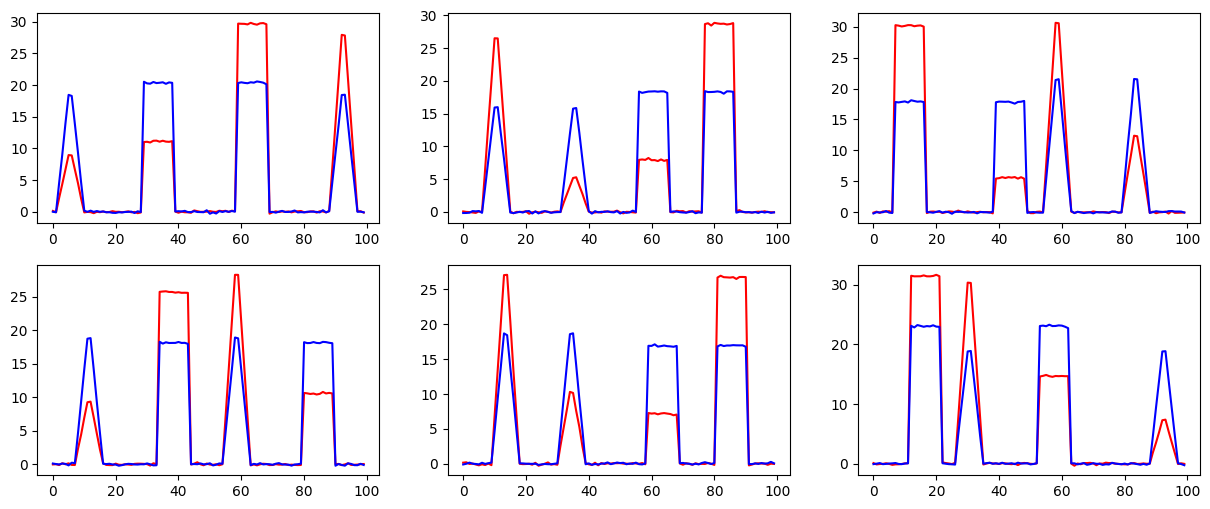

In [14]:
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(inputs[i, :, 0], color="r")
    plt.plot(outputs[i, :, 0], color="b")

**Question #13.** Check how a model made of a stack of 5 convolutional layers (use 64 filters in all layers except the last one) performs on this task. What loss function should you use?

In [19]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=1, kernel_size=5, padding="same", activation="relu"),
])
cnn_model.compile(loss="mse", optimizer="adam")
cnn_h = cnn_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=20)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 72.8537 - val_loss: 25.6974
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 23.0342 - val_loss: 22.1100
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.8786 - val_loss: 8.7189
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0488 - val_loss: 3.7534
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.4708 - val_loss: 1.8880
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5530 - val_loss: 1.5831
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4122 - val_loss: 2.9575
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4405 - val_loss: 1.2862
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9861 - val_loss: 1.7057
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1643 - val_loss: 1.2629
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9368 - val_loss: 1.1428
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


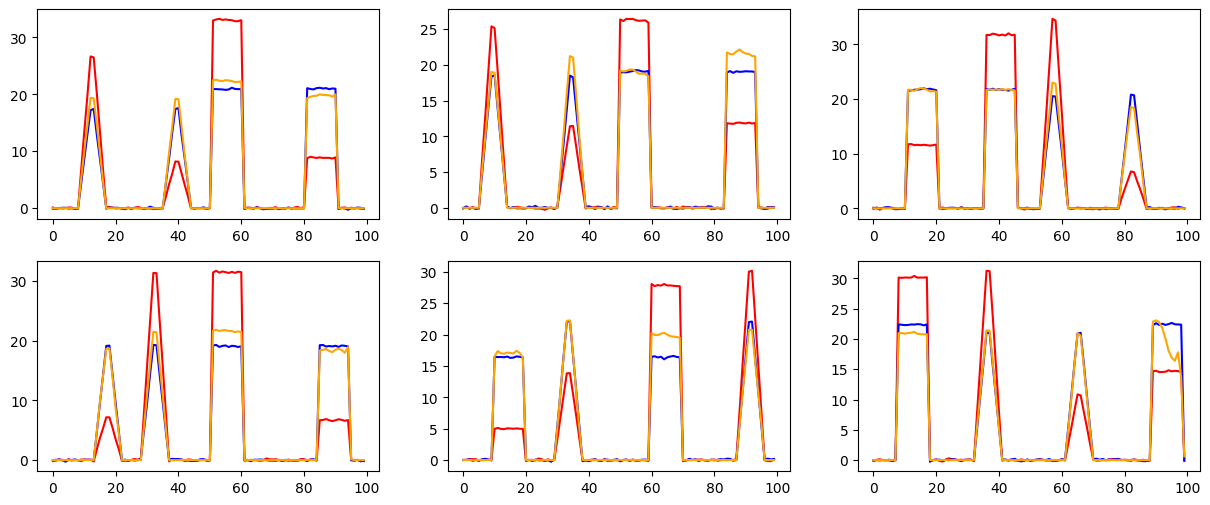

In [20]:
preds = cnn_model.predict(test_inputs)
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], color="r")
    plt.plot(test_outputs[i, :, 0], color="b")
    plt.plot(preds[i, :, 0], color="orange")

**Question #14.** Below is the definition of a multi-head self attention layer class. Use this class to replace the 3rd convolution in your model above by a **single-head self-attention layer** that would output a 64-dimensional time series.

In [21]:
from keras.layers import MultiHeadAttention

class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, num_heads, key_dim, dropout=0.):
        super().__init__(num_heads, key_dim, dropout=dropout)
    
    def build(self, x_shape):
        return super().build(query_shape=x_shape, value_shape=x_shape)
    
    def compute_output_shape(self, x_shape):
        return super().compute_output_shape(query_shape=x_shape, value_shape=x_shape)

    def call(self, x, return_attention_scores=False):
        return super().call(x, x, return_attention_scores=return_attention_scores)

In [23]:
attn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    MultiHeadSelfAttention(num_heads=1, key_dim=64),
    Conv1D(filters=64, kernel_size=5, padding="same", activation="relu"),
    Conv1D(filters=1, kernel_size=5, padding="same", activation="relu"),
])
attn_model.compile(loss="mse", optimizer="adam")
attn_h = attn_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=20)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 62.7931 - val_loss: 8.5906
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.9018 - val_loss: 3.7918
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3.6030 - val_loss: 3.4908
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.8975 - val_loss: 1.8810
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.7176 - val_loss: 1.4590
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.5417 - val_loss: 1.1505
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.1080 - val_loss: 1.1663
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.8914 - val_loss: 0.8215
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.8596 - val_loss: 0.9782
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.8781 - val_loss: 0.8666
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.8588 - val_loss: 0.7900
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0

**Question #15.** Compare both models in terms of validation loss.

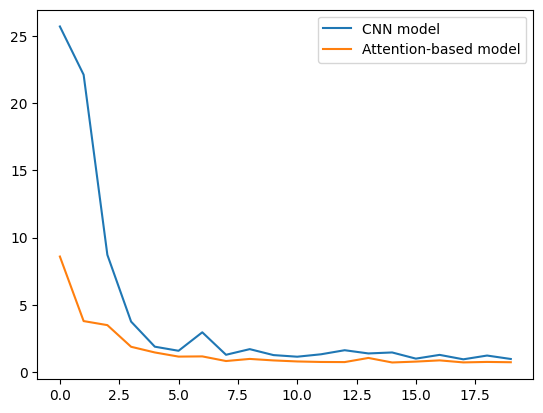

In [24]:
plt.plot(cnn_h.history["val_loss"], label="CNN model")
plt.plot(attn_h.history["val_loss"], label="Attention-based model")
plt.legend();

**Question #16.** Use test data for qualitative inspection of the produced outputs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


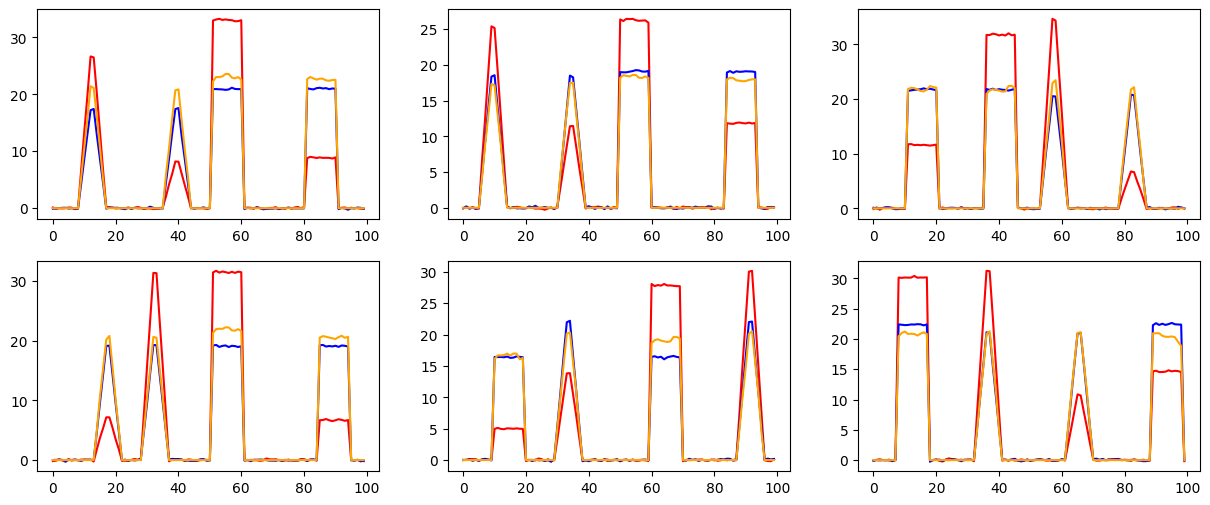

In [26]:
preds = attn_model.predict(test_inputs)
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], color="r")
    plt.plot(test_outputs[i, :, 0], color="b")
    plt.plot(preds[i, :, 0], color="orange")

**Question #17.** Use the code below to visualize average attention scores for the first 3 test series.

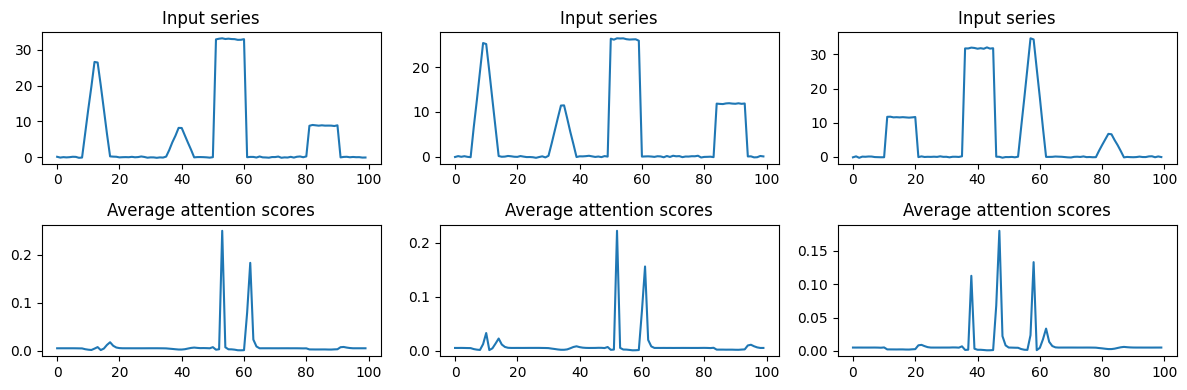

In [28]:
from keras.models import Sequential

def visualize_average_attention_scores(model, index_of_attention_layer, time_series):
    sub_model = Sequential(model.layers[:index_of_attention_layer])
    input_features = sub_model(time_series)
    att_layer = model.layers[index_of_attention_layer]
    _, weights = att_layer(input_features, return_attention_scores=True)

    plt.figure(figsize=(4*len(time_series), 4))
    for idx, ts in enumerate(time_series):
        plt.subplot(2, len(time_series), idx + 1)
        plt.plot(ts.ravel())
        plt.title("Input series")
        plt.subplot(2, len(time_series), len(time_series) + idx + 1)
        plt.plot(weights[idx, 0].numpy().mean(axis=0))
        plt.title("Average attention scores")
    plt.tight_layout()

visualize_average_attention_scores(attn_model, 2, test_inputs[:3])